In [12]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from nibabel import freesurfer as fs
import networkx as nx
from fastconsensus.core import construct_sparse_consensus_matrix,threshold_matrix,triadic_closure,check_convergence,get_algorithm
import igraph as ig
from bct.algorithms.centrality import participation_coef, module_degree_zscore
from bct.algorithms.degree import degrees_und
from copy import deepcopy
import os
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms

# Add helper_funcs to path and import helper functions
import sys
sys.path.append('helper_funcs')
from nodal_stats_overlapping_modules import *

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Load Glasser parcellation for right hemisphere

In [14]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices
glasser180_right_ctab = glasser180_right_ctab
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [15]:
# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

In [16]:
%%R -i oslom_modules_final_glasser180_right,module_orders -o oslom_modules_final_glasser180_right

# Tidy data
oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module_Number))%>% 
  filter(module != "Unassigned")

## Load Yeo 2011 7-network parcellation

In [17]:
yeo7_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot"
yeo7_right_vertices, yeo7_right_ctab, yeo7_right_names = fs.read_annot(yeo7_right_file)

yeo7_right_vertices = yeo7_right_vertices
yeo7_right_ctab = yeo7_right_ctab
yeo7_right_names = [name.decode() for name in yeo7_right_names]

# Create Yeo 7 right hemi lookup table
yeo7_right_LUT = pd.read_csv("yeo7_lookup.csv")

# Convert yeo17 array to dataframe
yeo7_right_df = pd.DataFrame({'index': yeo7_right_vertices, 'vertex_number': np.arange(0, len(yeo7_right_vertices))})
yeo7_right_df['Yeo7_RH_ROI'] = yeo7_right_df['index'].map(yeo7_right_LUT.set_index('index')['Yeo7_RH_ROI'])

# Drop index
yeo7_right_df = yeo7_right_df.drop(columns=['index'])

## Load Margulies 2016 principal gradient vertices

In [18]:
# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_PG1 = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_PG1_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG1, '164k', 'R')[0]
margulies_PG1_fsaverage_right_vertices = margulies_PG1_fsaverage_right.agg_data()

margulies_PG2 = fetch_annotation(source='margulies2016', desc='fcgradient02')
margulies_PG2_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG2, '164k', 'R')[0]
margulies_PG2_fsaverage_right_vertices = margulies_PG2_fsaverage_right.agg_data()

# Combine PG1 and PG2 across vertices
margulies_PG_fsaverage_right_df = pd.DataFrame({'PG1_value': margulies_PG1_fsaverage_right_vertices, 
                                                'PG2_value': margulies_PG2_fsaverage_right_vertices, 
                                                'vertex_number': np.arange(0, len(margulies_PG1_fsaverage_right_vertices))})



[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cort

## Merge all the data!

In [19]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with Yeo 7 networks
merged_df = pd.merge(merged_df, yeo7_right_df, on='vertex_number', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_PG_fsaverage_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???" and Yeo7_RH_ROI != "???"')

# Compute the mean PG1/PG2 values by region
mean_PG_value_by_region = (merged_df
                            .groupby(['Glasser_RH_ROI'])[['PG1_value', 'PG2_value']]
                            .mean()
                            .reset_index()
                            .merge(oslom_modules_final_glasser180_right, how='left'))

## Load overlapping community detection algorithm (OCDA) modules

In [20]:
# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])
oslom_modules_final_glasser180_right_long = pd.read_csv(f"../data/OSLOM30_final_module_assignments_with_duplicates.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

# Define data path
data_path = "/Users/abry4213/data/OCDA/"

# Convert oslom_modules_final_glasser180_right_long to a wide format, with each row correspoding to a region and each column to a module
# Values should be 1 if the region is in the module, 0 otherwise
oslom_modules_final_glasser180_right_wide = oslom_modules_final_glasser180_right_long.assign(value=1).pivot(index='Glasser_RH_ROI', columns='module', values='value').fillna(0)
oslom_modules_final_glasser180_right_wide.to_csv("../data/OSLOM30_final_module_assignments_wide_binary.csv", index=False, header=False)

# Load brain region labels
brain_regions = pd.read_csv("../data/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI']).drop('node', axis=1)
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

# Filter to node_index<=180 and drop node_index 92
brain_regions = brain_regions[brain_regions['node_index']<=180]
brain_regions = brain_regions[brain_regions['node_index']!=92]

# Load brain region names
region_names = brain_regions.Glasser_RH_ROI.values

# Loading community structure as determined by Louvain
louvain_consensus_results = pd.read_csv("../data/louvain_community_assignments_BCT_gamma1.csv").assign(Glasser_RH_ROI=region_names)

# Load right-hemisphere connectivity matrix
RH_connectivity_data = pd.DataFrame(scipy.io.loadmat('../data/HCP_Connectome/RH.mat')['RH'])

# Drop column/row 91
RH_connectivity_data = RH_connectivity_data.drop(index=91, columns=91)

# Assign region names to rows and columns
RH_connectivity_data.index = region_names
RH_connectivity_data.columns = region_names

# Load right-hemisphere connectivity matrix, with added nodes for OSLOM overlap
RH_connectivity_data_overlap = pd.DataFrame(scipy.io.loadmat('../data/HCP_Connectome/RH_with_OSLOM_duplicates.mat')['RH_with_repeats'])

# Load results with duplicates for OSLOM
oslom_modules_final_glasser180_right = pd.read_csv("../data/OSLOM30_final_module_assignments.csv")
oslom_modules_final_glasser180_right_long = pd.read_csv("../data/OSLOM30_final_module_assignments_with_duplicates.csv")
oslom_modules_final_glasser180_right_long = oslom_modules_final_glasser180_right_long.merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping']], on='Glasser_RH_ROI', how='left')

In [21]:
%%R -i region_names,oslom_modules_final_glasser180_right,louvain_consensus_results -o oslom_modules_final_glasser180_right,louvain_consensus_results

oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>% 
    arrange(Glasser_RH_ROI)

louvain_consensus_results <- louvain_consensus_results %>%
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>%
    arrange(Glasser_RH_ROI)

### Compute node degree (independent of partition)

In [22]:
nodal_degrees = (degrees_und(RH_connectivity_data)
                 .reset_index()
                 .rename(columns={'index': 'Glasser_RH_ROI', 0: 'degree'})
                 .merge(oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left'))


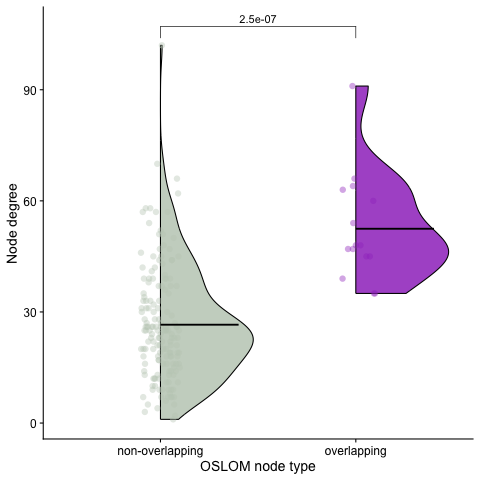

In [23]:
%%R -i nodal_degrees

nodal_degrees %>% 
    ggplot(data=., mapping=aes(x=overlapping, y=degree, fill=overlapping)) +
    ylab("Node degree") +
    xlab("OSLOM node type") +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(aes(color=overlapping), position = position_jitter(width = 0.1, height=0),
                            size = 3, alpha=0.4, stroke=0) +
    ggpubr::stat_compare_means(method="wilcox", comparisons=list(c("overlapping", "non-overlapping")),
                            #    aes(label = after_stat(p.signif))
                               ) +
    scale_fill_manual(values=c("overlapping"="#9F3BC5",
                               "non-overlapping"="#c1cdbf")) +  
    scale_color_manual(values=c("overlapping"="#9F3BC5",
                               "non-overlapping"="#c1cdbf")) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.4, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=.2)) +
    theme(legend.position="none")
# ggsave("../plots/degree_by_OSLOM_node_type.svg", width=3, height=4, dpi=300)

## Compute participation coefficient (P) and module degree, z-scored (Z)

In [24]:
louvain_P = participation_coef(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
oslom_P = participation_coef(RH_connectivity_data_overlap.values, oslom_modules_final_glasser180_right_long['module'].values)

louvain_Z = module_degree_zscore(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
# oslom_Z = module_degree_zscore(RH_connectivity_data_overlap.values, oslom_modules_final_glasser180_right_long['module'].values)
oslom_Z_multi = module_degree_zscore_multi(RH_connectivity_data.values, oslom_modules_final_glasser180_right_wide.values, flag=0)

louvain_structure_df = (louvain_consensus_results
                        .merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping', 'module']], 
                               on="Glasser_RH_ROI", how="left")
                        .assign(louvain_P=louvain_P, louvain_Z=louvain_Z)
                        .rename(columns={'module': 'OSLOM_module'})
                        )

oslom_structure_df = (oslom_modules_final_glasser180_right_long
                      .assign(oslom_P = oslom_P)
                      .drop_duplicates(subset=['Glasser_RH_ROI', 'overlapping', 'oslom_P'])
                      .assign(oslom_Z = oslom_Z_multi)
                      )
oslom_structure_df.head()

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/bct/algorithms/centrality.py:687: RuntimeWarning: invalid value encountered in divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


,node,Glasser_RH_ROI,module,overlapping,oslom_P,oslom_Z
0,1,R_V1_ROI,2,non-overlapping,0.440614,1.416640
1,2,R_MST_ROI,4,non-overlapping,0.439160,-1.177294
2,3,R_V6_ROI,2,non-overlapping,0.377287,0.198764
3,4,R_V2_ROI,2,non-overlapping,0.496729,1.326330
4,5,R_V3_ROI,2,non-overlapping,0.477468,2.228843


### Plot Z vs. P for Louvain

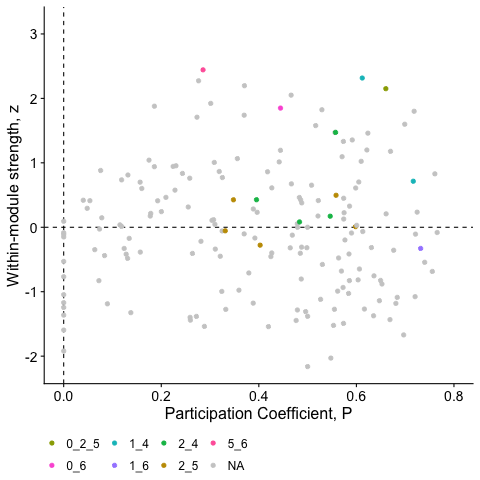

In [25]:
%%R -i louvain_structure_df,module_orders,oslom_structure_df

z_min <- min(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
z_max <- max(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
p_min <- min(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))
p_max <- max(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

louvain_structure_df %>% 
    mutate(row_index = row_number()) %>%
    mutate(color_module = ifelse(overlapping=='overlapping', OSLOM_module, NA_character_)) %>%
    ggplot(data=., mapping=aes(x=louvain_P, y=louvain_Z, color=color_module)) +
    geom_vline(xintercept=0, linetype='dashed') +
    geom_hline(yintercept=0, linetype='dashed') +
    scale_x_continuous(limits=c(p_min, p_max)) +
    scale_y_continuous(limits=c(z_min, z_max)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray80") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/Louvain_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

Joining with `by = join_by(Glasser_RH_ROI, overlapping)`


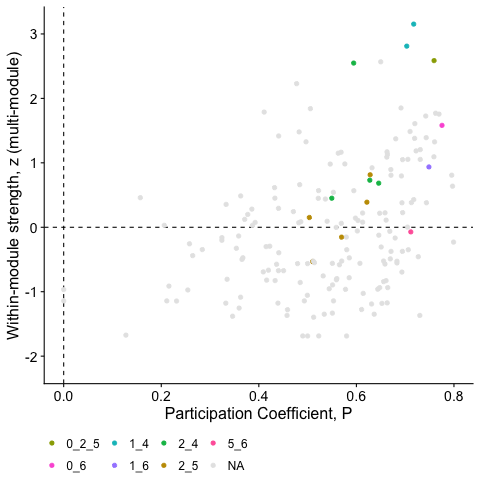

In [26]:
%%R -i louvain_structure_df,module_orders,oslom_structure_df

z_min <- min(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
z_max <- max(c(louvain_structure_df$louvain_Z, oslom_structure_df$oslom_Z))
p_min <- min(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))
p_max <- max(c(louvain_structure_df$louvain_P, oslom_structure_df$oslom_P))

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

oslom_structure_df %>% 
    mutate(row_index = row_number()) %>%
    left_join(., oslom_modules_final_glasser180_right %>% rename('OSLOM_module' = 'module') %>% select(Glasser_RH_ROI, overlapping, OSLOM_module)) %>%
    mutate(color_module = ifelse(overlapping=='overlapping', OSLOM_module, NA_character_)) %>%
    group_by(Glasser_RH_ROI) %>%
    filter(abs(oslom_Z) == max(abs(oslom_Z))) %>%
    ggplot(data=., mapping=aes(x=oslom_P, y=oslom_Z, color=color_module)) +
    geom_vline(xintercept=0, linetype='dashed') +
    geom_hline(yintercept=0, linetype='dashed') +
    scale_x_continuous(limits=c(p_min, p_max)) +
    scale_y_continuous(limits=c(z_min, z_max)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z (multi-module)") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray90") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/OSLOM_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

## Compare p/Z in Louvain vs. OSLOM space

In [27]:
P_z_data_to_plot_all = (oslom_structure_df[['Glasser_RH_ROI', 'oslom_P', 'oslom_Z']]
                  .merge(louvain_structure_df[['Glasser_RH_ROI', 'louvain_P', 'louvain_Z']], 
                         on='Glasser_RH_ROI', how='left')
                    .assign(P_diff = lambda x: x.oslom_P - x.louvain_P,
                                Z_diff = lambda x: x.oslom_Z - x.louvain_Z)
                    .merge(louvain_structure_df, on=['Glasser_RH_ROI', 'louvain_P', 'louvain_Z'])
                                )

# Filter to overlapping regions and then to the instance with the max |Z_diff
P_z_data_to_plot = P_z_data_to_plot_all.query("overlapping == 'overlapping'").groupby('Glasser_RH_ROI').apply(lambda x: x.loc[abs(x.Z_diff).idxmax()])

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_99129/4131179278.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  P_z_data_to_plot = P_z_data_to_plot_all.query("overlapping == 'overlapping'").groupby('Glasser_RH_ROI').apply(lambda x: x.loc[abs(x.Z_diff).idxmax()])


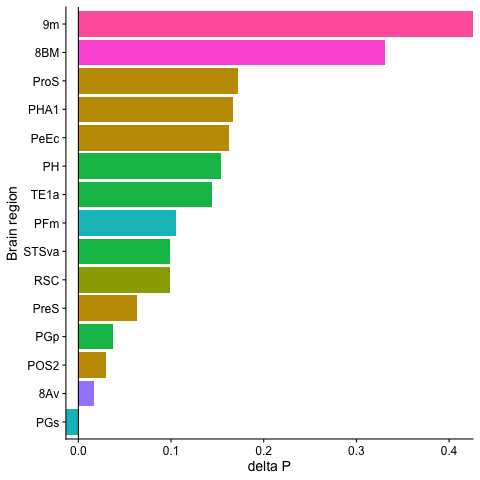

In [28]:
%%R -i P_z_data_to_plot,module_orders

# Set color names
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

P_z_data_to_plot %>% 
    filter(overlapping=="overlapping") %>% 
    mutate(P_diff = as.numeric(P_diff),
           Glasser_RH_ROI = gsub("R_|_ROI", "", Glasser_RH_ROI),
           Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, P_diff, .fun='mean')) %>%
    ggplot(mapping=aes(x=Glasser_RH_ROI, y=P_diff, fill=OSLOM_module)) +
    geom_bar(stat='identity')+ 
    scale_fill_manual(values=colormap) +
    geom_hline(yintercept=0) +
    scale_y_continuous(expand=c(0,0)) +
    coord_flip() +
    xlab("Brain region") +
    ylab("delta P") +
    theme(legend.position="none")
# ggsave("../plots/Delta_P_Louvain_to_OSLOM.svg", width=3, height=4.5, units="in", dpi=300)

## Compare 9m/8BM community assignment in Louvain vs. OSLOM

In [29]:
# What region do we want? ProS
target_regions_to_plot = ["R_9m_ROI", "R_8BM_ROI"]

# Find the indices of these names in region_names array as an array
target_region_indices = np.where(np.isin(region_names, target_regions_to_plot))[0]

# Keep all edges that connect to node 127 (with base 0, after removing node 92, that's node 125 in Python)
RH_connectivity_arr = np.array(RH_connectivity_data)
keepNodes = RH_connectivity_arr[target_region_indices, :] > 0

# Keep just the connected nodes
keepNodes = np.any(keepNodes, axis=0)
keepNodes_indices = np.where(keepNodes)[0] + 1

# Subset RH_connectivity_arr rows and columns to only the indices in keepNode that are 1
RH_connectivity_arr_sub = RH_connectivity_arr[keepNodes, :][:, keepNodes]
numNodes = RH_connectivity_arr_sub.shape[0]

# Subset OSLOM results to only include nodes in the subnetwork
oslom_structure_df_connected_subset = oslom_structure_df.query("node in @keepNodes_indices").drop(columns=['node']).drop_duplicates(subset=["Glasser_RH_ROI"]).assign(node_index = lambda x: range(len(x.module)))

# Subset region_labels to only include nodes in the subnetwork
region_names_sub = [d for d, m in zip(region_names, keepNodes) if m]

# Convert to a dataframe
region_names_sub = pd.DataFrame(region_names_sub, columns=['Glasser_RH_ROI'])
region_names_sub['index_sub'] = range(len(region_names_sub))
target_region_index_sub = region_names_sub.query("Glasser_RH_ROI in @target_regions_to_plot").index_sub.values

# Filter community assignments to only include nodes in the subnetwork
oslom_subset = oslom_modules_final_glasser180_right.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))
louvain_subset = louvain_structure_df.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))

### Plot Louvain structure for 8BM + 9m

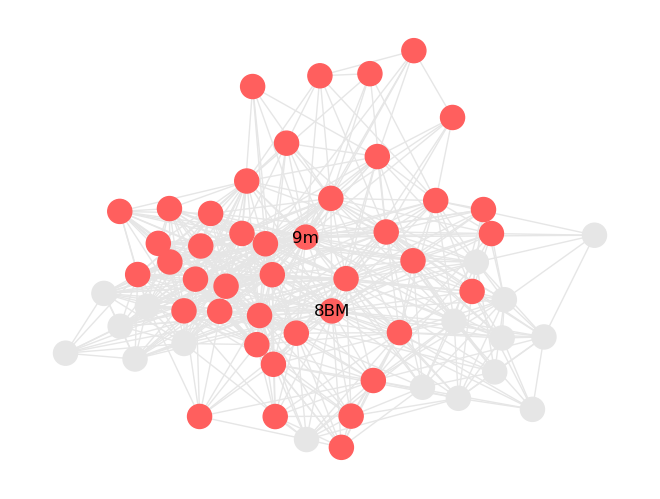

In [30]:
louvain_community_with_8BM_9m = louvain_subset.query("Glasser_RH_ROI in @target_regions_to_plot").Louvain_community.values[0]
# Highlighting the nodes belonging to community 0 which is split into several communities by OSLOM
nodes_louvain_8BM_9m_cluster = louvain_subset.query("Louvain_community == @louvain_community_with_8BM_9m").node_index.tolist()
nodes_louvain_other = louvain_subset.query("Louvain_community != @louvain_community_with_8BM_9m").node_index.tolist()

# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_louvain = nx.Graph(RH_connectivity_arr_sub)

# Get short names
region_names_sub_short = region_names_sub.Glasser_RH_ROI.str.replace("R_", "").str.replace("_ROI", "").values

# Color nodes by community in G
labels = {}    
color_map = []
for node in G_louvain:
    if node in target_region_index_sub:
        labels[node] = region_names_sub_short[node]
    if node in nodes_louvain_8BM_9m_cluster:
        color_map.append('#FF5F5E')
    else: 
        color_map.append('#E6E6E6')      
nx.draw(G_louvain, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
# plt.savefig("../Plots/Louvain_9m_8BM_network_graph.svg", format="SVG")

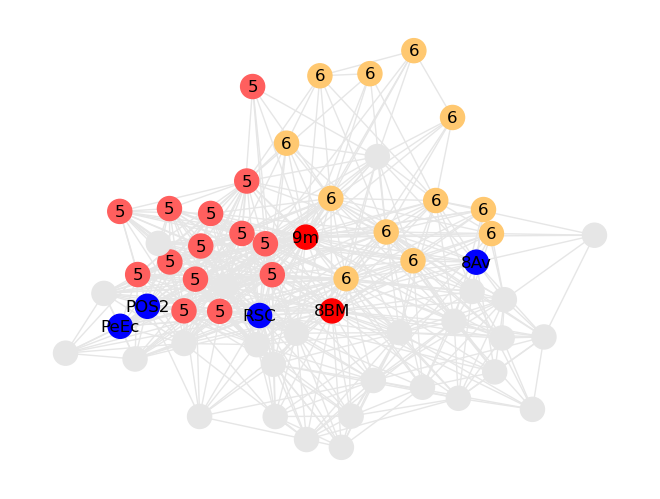

In [31]:
# Set the seed for a reproducible network graph
np.random.seed(127)

oslom_module_overlap = np.unique(oslom_structure_df.query("Glasser_RH_ROI in @target_regions_to_plot").module.values)

# Highlighting the nodes belonging to community 0 which is split into several communities by OSLOM
nodes_OSLOM_8BM_9m_cluster = np.unique(oslom_structure_df_connected_subset.query("module in @oslom_module_overlap").node_index).tolist()
nodes_OSLOM_other = oslom_structure_df_connected_subset.query("module not in @oslom_module_overlap").node_index.tolist()

node_overlap = oslom_structure_df_connected_subset[['Glasser_RH_ROI', 'node_index']].drop_duplicates().merge(oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left').query("overlapping=='overlapping'")

# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_oslom = nx.Graph(RH_connectivity_arr_sub)

# Get short names
region_names_sub_short = region_names_sub.Glasser_RH_ROI.str.replace("R_", "").str.replace("_ROI", "").values

# Color nodes by community in G
labels = {}    
color_map = []
for node in G_oslom:
    if node in target_region_index_sub:
        labels[node] = region_names_sub_short[node]
        color_map.append('red')
    elif node in node_overlap.node_index.values:
        color_map.append('blue')
        labels[node] = region_names_sub_short[node]
    elif node in nodes_OSLOM_8BM_9m_cluster:
        # For each module in oslom_module_overlap, assign a different color
        if oslom_structure_df_connected_subset.query("node_index == @node").module.values[0] == oslom_module_overlap[0]:
            color_map.append('#FF5F5E')
            labels[node] = oslom_module_overlap[0]
        elif oslom_structure_df_connected_subset.query("node_index == @node").module.values[0] == oslom_module_overlap[1]:
            color_map.append('#FFC870')
            labels[node] = oslom_module_overlap[1]
        elif oslom_structure_df_connected_subset.query("node_index == @node").module.values[0] == oslom_module_overlap[2]:
            color_map.append('green')
            labels[node] = oslom_module_overlap[2]

        # color_map.append('#FF5F5E')
    else: 
        color_map.append('#E6E6E6')      
nx.draw(G_oslom, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
# plt.savefig("../Plots/OSLOM_8BM_9m_network_graph.svg", format="SVG")


### Do PG1 values relate to OSLOM z/P?

In [32]:
PG_values_vs_nodal_stats = (mean_PG_value_by_region
                            .merge(oslom_structure_df.drop(['module', 'overlapping'], axis=1), on=['Glasser_RH_ROI'], how='left')
                            # .query("overlapping == 'overlapping'")
                            .drop_duplicates(subset=['Glasser_RH_ROI', 'PG1_value', 'oslom_P'])
                            .merge(louvain_structure_df[['Glasser_RH_ROI', 'louvain_P', 'louvain_Z']], on=['Glasser_RH_ROI'], how='left')
)

PG_values_vs_nodal_stats_overlapping = PG_values_vs_nodal_stats.query("overlapping == 'overlapping'")

`geom_smooth()` using formula = 'y ~ x'


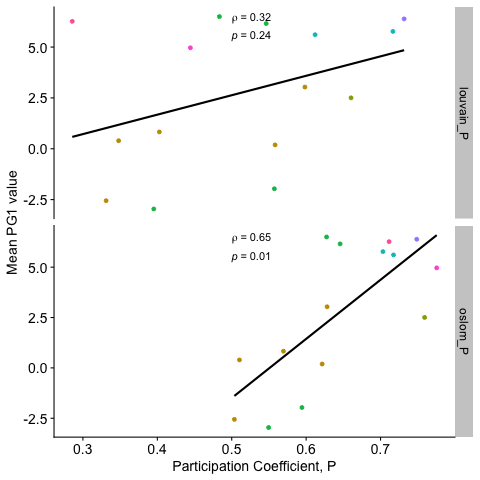

In [33]:
%%R -i PG_values_vs_nodal_stats_overlapping,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

PG_values_vs_nodal_stats_overlapping %>% 
    pivot_longer(cols=c("louvain_P", "oslom_P"), names_to="Partitioning", values_to="P") %>%
    ggplot(data=., mapping=aes(y=PG1_value, x=P))  +
    geom_smooth(method="lm", se=FALSE, color="black") +
    facet_grid(Partitioning ~ ., scales="free_y") +
    ggpubr::stat_cor(method="spearman", label.x=0.5, label.y=6, label.sep="\n", cor.coef.name = 'rho') +
    geom_point(aes(color=module)) +
    scale_color_manual(values=colormap) +
    xlab("Participation Coefficient, P") +
    ylab("Mean PG1 value") +
    theme(legend.position="none",
          axis.text = element_text(size=14))
# ggsave("../Plots/PG1_vs_P_OSLOM_overlapping_regions.svg", width=3.25, height=4.5, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing non-finite outside the scale range (`stat_cor()`). 

R[write to console]: 3: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



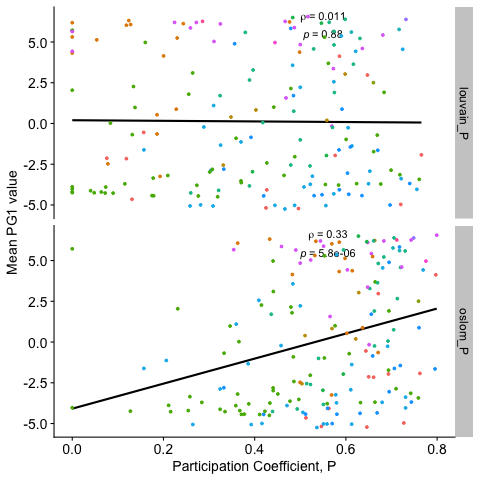

In [34]:
%%R -i PG_values_vs_nodal_stats,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

PG_values_vs_nodal_stats %>% 
    pivot_longer(cols=c("louvain_P", "oslom_P"), names_to="Partitioning", values_to="P") %>%
    ggplot(data=., mapping=aes(y=PG1_value, x=P))  +
    geom_smooth(method="lm", se=FALSE, color="black") +
    facet_grid(Partitioning ~ ., scales="free_y") +
    ggpubr::stat_cor(method="spearman", label.x=0.5, label.y=6, label.sep="\n", cor.coef.name = 'rho') +
    geom_point(aes(color=module), size=1) +
    scale_color_manual(values=colormap) +
    xlab("Participation Coefficient, P") +
    ylab("Mean PG1 value") +
    theme(legend.position="none",
          axis.text = element_text(size=14))
# ggsave("../Plots/PG1_vs_P_OSLOM_all_regions.svg", width=3.25, height=4.5, units="in", dpi=300)